In [1]:
import os
import sys

# Add the src directory to the sys.path
try:
    # Try using __file__ in a script
    current_dir = os.path.dirname(__file__)
except NameError:
    # Use current working directory in Jupyter notebooks
    current_dir = os.path.join(os.path.dirname(os.getcwd()), 'src')
sys.path.append(os.path.join(current_dir, 'src'))

# import libraries
import fire
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import pytagi.metric as metric
from pytagi import Normalizer as normalizer
from pytagi import exponential_scheduler
from pytagi.nn import LSTM, Linear, OutputUpdater, Sequential

from data_loader import TimeSeriesDataloader
from hybrid import LSTM_SSM, process_input_ssm


In [2]:
# Define parameters
batch_size = 1
sigma_v = 1
output_col = [0]
num_features = 5
input_seq_len = 26
output_seq_len = 1
seq_stride = 1

In [3]:
# Dataset
data_file = "../data/HQ/LGA007PIAP-E010_Y_train.csv"
df = pd.read_csv(data_file, skiprows=1, delimiter=",", header=None)

# Time
time_file = "../data/HQ/LGA007PIAP-E010_Y_train_datetime.csv"
time = pd.read_csv(time_file, skiprows=1, delimiter=",", header=None)
time = pd.to_datetime(time[0], format='%Y-%m-%d %H:%M:%S')

# # plotting
# plt.figure()
# plt.figure(figsize=(10, 6))
# plt.plot(time, df.values[:,output_col], color='r')

In [4]:
# split data into training, validation and test sets
train_start = '2010-02-07 00:00:00'
val_start = '2013-03-23 00:00:00'
val_end = '2014-03-23 00:00:00'

# Filter data for the two periods
train_period_data = df.values[(time >= train_start) & (time <= val_start)]
val_period_data = df.values[(time >= val_start) & (time <= val_end)]

# # Plot the data
# plt.figure(figsize=(10, 6))
# # Plot for training period
# plt.plot(time[(time >= train_start) & (time <= val_start)], train_period_data[:,output_col], label='Training Period', color='k')
# # Plot for validation period
# plt.plot(time[(time >= val_start) & (time <= val_end)], val_period_data[:,output_col], label='Validation Period', color='b')



In [5]:
train_time = np.array(time[(time >= train_start) & (time <= val_start)], dtype="datetime64") 
train_time = train_time.reshape(-1, 1)
train_dtl = TimeSeriesDataloader(
        train_period_data,
        train_time,
        output_col=output_col,
        input_seq_len=input_seq_len,
        output_seq_len=output_seq_len,
        num_features=num_features,
        stride=seq_stride,
        time_covariates = ['week_of_year'],  # 'hour_of_day','day_of_week', 'week_of_year', 'month_of_year','quarter_of_year'
    )


val_time = np.array(time[(time >= val_start) & (time <= val_end)], dtype="datetime64") 
val_time = val_time.reshape(-1, 1)
val_dtl = TimeSeriesDataloader(
        val_period_data,
        val_time,
        output_col=output_col,
        input_seq_len=input_seq_len,
        output_seq_len=output_seq_len,
        num_features=num_features,
        stride=seq_stride,
        time_covariates = ['week_of_year'],  # 'hour_of_day','day_of_week', 'week_of_year', 'month_of_year','quarter_of_year'
    )

In [6]:
# Network
net = Sequential(
    LSTM(1, 30, input_seq_len),
    LSTM(30, 30, input_seq_len),
    Linear(30 * input_seq_len, 1),
)
net.set_threads(8)

# State-space models: for baseline hidden states
hybrid = LSTM_SSM(
    neural_network = net,           # LSTM
    baseline = 'trend', # 'level', 'trend', 'acceleration', 'ETS'
    zB  = np.array([0.1, 1E-4]),    # initial mu for baseline hidden states
    SzB = np.array([1E-5, 1E-5])    # var
)

In [13]:
num_epochs = 30
# -------------------------------------------------------------------------#
# Training
mses = []

pbar = tqdm(range(num_epochs), desc="Training Progress")
for epoch in pbar:
    batch_iter = train_dtl.create_data_loader(batch_size, shuffle=False)

    # Decaying observation's variance
    sigma_v = exponential_scheduler(
        curr_v=sigma_v, min_v=0.3, decaying_factor=0.99, curr_iter=epoch
    )
    var_y = np.full((batch_size * len(output_col),), sigma_v**2, dtype=np.float32)

    # Initialize list to save
    hybrid.init_ssm_hs()
    mu_preds_lstm = []
    var_preds_lstm = []
    mu_preds_unnorm = []
    obs_unnorm = []
    #

    for x, y in batch_iter:
        mu_x, var_x = process_input_ssm(
            mu_x = x, mu_preds_lstm = mu_preds_lstm, var_preds_lstm = var_preds_lstm,
            input_seq_len = input_seq_len,num_features = num_features,
            )

        # Feed forward
        y_pred, _,m_pred, v_pred = hybrid(mu_x, var_x)
        # Backward
        hybrid.backward(mu_obs = y, var_obs = var_y)

        # Training metric
        pred = normalizer.unstandardize(
            y_pred.flatten(), train_dtl.x_mean[output_col], train_dtl.x_std[output_col]
        )
        obs = normalizer.unstandardize(
            y, train_dtl.x_mean[output_col], train_dtl.x_std[output_col]
        )
        mse = metric.mse(pred, obs)
        mses.append(mse)
        mu_preds_lstm.extend(m_pred)
        var_preds_lstm.extend(v_pred)
        obs_unnorm.extend(y)
        mu_preds_unnorm.extend(y_pred)

    # Smoother
    hybrid.smoother()

    # Progress bar
    pbar.set_description(
        f"Epoch {epoch + 1}/{num_epochs}| mse: {np.nanmean(mses):>7.2f}",
        refresh=True,
    )

Epoch 30/30| mse:    0.04: 100%|██████████| 30/30 [00:11<00:00,  2.57it/s]


In [14]:
# Testing
test_batch_iter = val_dtl.create_data_loader(batch_size, shuffle=False)

# Initialize list to save
mu_preds = []
var_preds = []
y_test = []
obs_test_unnorm = []
#

for x, y in test_batch_iter:
    mu_x, var_x = process_input_ssm(
        mu_x = x, mu_preds_lstm = mu_preds_lstm, var_preds_lstm = var_preds_lstm,
        input_seq_len = input_seq_len,num_features = num_features,
    )
    # Feed forward
    y_pred, Sy_red, m_pred, v_pred = hybrid(mu_x, var_x)

    mu_preds.extend(y_pred)
    var_preds.extend(Sy_red + sigma_v**2)
    y_test.extend(y)
    mu_preds_lstm.extend(m_pred)
    var_preds_lstm.extend(v_pred)

mu_preds = np.array(mu_preds)
std_preds = np.array(var_preds) ** 0.5
y_test = np.array(y_test)
obs_test_unnorm = y_test
mu_preds_unnorm_test = mu_preds
std_preds_unnorm_test = std_preds

mu_preds = normalizer.unstandardize(
    mu_preds, train_dtl.x_mean[output_col], train_dtl.x_std[output_col]
)
std_preds = normalizer.unstandardize_std(std_preds, train_dtl.x_std[output_col])

y_test = normalizer.unstandardize(
    y_test, train_dtl.x_mean[output_col], train_dtl.x_std[output_col]
)

# Compute log-likelihood
mse = metric.mse(mu_preds, y_test)
log_lik = metric.log_likelihood(
    prediction=mu_preds, observation=y_test, std=std_preds
)

#############
MSE           :  1.43
Log-likelihood: -6.39


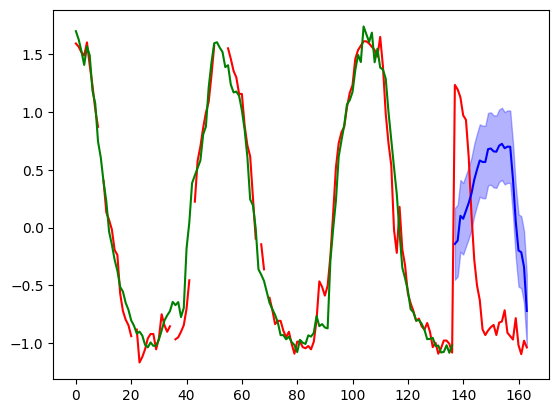

In [15]:
#
obs = np.concatenate((obs_unnorm,obs_test_unnorm), axis=0)
idx_train = range(0,len(obs_unnorm))
idx_test = range(len(obs_unnorm),len(obs))
idx = np.concatenate((idx_train,idx_test),axis=0)
mu_preds_unnorm_test = mu_preds_unnorm_test.flatten()
std_preds_unnorm_test = std_preds_unnorm_test.flatten()

# figure for final test predictions
plt.figure()
plt.plot(idx,obs, color='r',label=r"data")
plt.plot(idx_test, mu_preds_unnorm_test, color='b',label=r"test prediction")
plt.fill_between(idx_test, mu_preds_unnorm_test - std_preds_unnorm_test, mu_preds_unnorm_test + std_preds_unnorm_test, color='blue', alpha=0.3, label='±1 SD')
plt.plot(idx_train, mu_preds_unnorm,color='g', label=r"train prediction")

print("#############")
print(f"MSE           : {mse: 0.2f}")
print(f"Log-likelihood: {log_lik: 0.2f}")